# Midterm 2 Assignment 3 Davide Amadei

### Imports

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from typing import Iterator
import time
from sewar.full_ref import uqi

### Utility functions

In [2]:
def mse(x: np.ndarray, y: np.ndarray) -> np.ndarray:
    """Mean Squared Error

    Parameters
    ----------
    x : np.ndarray
        first input
    y : np.ndarray
        second input

    Returns
    -------
    np.ndarray
        returns the Mean Squared Error computed on x and y
    """
    return ((x-y)**2).mean()

def sigmoid(x: np.ndarray) -> np.ndarray:
    """sigmoid function applied elementwise to a matrix or vector

    Parameters
    ----------
    x : np.ndarray
        input matrix or vector

    Returns
    -------
    np.ndarray
        matrix or vector of same size of input containing elementwise sigmoid
    """
    return 1/(1+np.exp(-x))

def plot_images(indices: list[int], og:np.ndarray, recon:np.ndarray, 
                labels:np.ndarray, figsize:tuple[float, float]=None) -> None:
    """simple function to plot comparisons between original images and the ones reconstructed by the RBM

    Parameters
    ----------
    indices : list[int]
        list of indices of the data to be shown
    og : np.ndarray
        original images
    recon : np.ndarray
        reconstructed images
    labels : np.ndarray
        labels of the data
    figsize : tuple[float, float], optional
        size of the image to be shown. If None use (len(indices)*1.5, 3) as size, by default None
    """
    if figsize is None:
        figsize = (len(indices)*1.5, 3)

    fig, axes = plt.subplots(2, len(indices), figsize=figsize)

    i = 0
    for index in indices:
        loss = np.round(mse(og[index], recon[index]), 4)
        uqi_loss = np.round(uqi(og[index], recon[index]), 4)

        # row 1, original image
        ax = axes[0, i]
        ax.axis("off")
        ax.set_title(f"{labels[index]}")
        ax.imshow(og[index], cmap="gray")

        # row 2, reconstructed image
        ax = axes[1, i]
            
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])

        ax.set_xlabel(f"MSE: {loss}\n"
                      f"UQI: {uqi_loss}")
        
        ax.imshow(recon[index], cmap="gray")
        i+=1
    plt.show()

### Function to read the MNIST dataset
As the MNIST dataset is provided in idx format it has to be read from the original file to be converted into a usable form.<br>
This function does exactly that, reading and decoding the file based on the format explained on the [MNIST site](http://yann.lecun.com/exdb/mnist/).

In [3]:
def read_MNIST_file(path: str, reshape: bool = False) -> tuple[tuple, np.ndarray]:
    """simple utility function to read a file containing MNIST datasets and labels

    Parameters
    ----------
    path : str
        path containing the file to load
    reshape : bool, optional
        flag determining wheter the dataset is returned already reshaped as images or flattened.
        If True each element of the dataset is reshaped to a matrix of size 28x28, 
        else each element is a vector of size 784, by default False

    Returns
    -------
    tuple[tuple, np.ndarray]
        the shape of the output data and either the dataset or the labels read from the file

    Raises
    ------
    ValueError
        if the magic numbers of the file are wrong
    """
    with open(path, "rb") as f:
        magic = int.from_bytes(f.read(4))
        n_items = int.from_bytes(f.read(4))

        # image file
        if magic == 2051:
            n_rows = int.from_bytes(f.read(4))
            n_columns = int.from_bytes(f.read(4))

            # if reshape is true change the output shape
            if reshape:
                shape = (n_items, n_rows, n_columns)
            else:
                shape = (n_items, n_rows * n_columns)
            images = np.ndarray(shape)

            # read each image one by one
            for i in range(n_items):
                img_buffer = f.read(n_rows*n_columns)
                # convert binary data buffer to numpy int array
                img = np.frombuffer(img_buffer, np.uint8)

                # reshape the image if needed
                if reshape:
                    img = np.reshape(img, (n_rows, n_columns))

                images[i] = img
            # the images are returned already normalized between 0 and 1,
            # necessary for data to be usable
            return (shape, images/255)
        # label file
        elif magic == 2049:
            label_buffer = f.read(n_items)
            # convert binary data buffer to numpy int array
            labels = np.frombuffer(label_buffer, np.uint8)
            return (labels.shape, labels)
        # wrong type of file
        else:
            raise ValueError("wrong file format")

Load the training set and the test set with its labels.

In [4]:
tr_img_shape, tr_images = read_MNIST_file("./data/train-images-idx3-ubyte")
ts_img_shape, ts_images = read_MNIST_file("./data/t10k-images-idx3-ubyte")
_, test_labels = read_MNIST_file("./data/t10k-labels-idx1-ubyte")

## Restricted Boltzmann Machine implementation
This is the implementation of the Restricted Boltzmann Machine and of all the needed methods to train it and to use it for reconstructing data from a given sample.<br>
All the sampling is done binarizing the data as seen in the code example in class. This means starting from an array of elements $0 \leq x \leq 1$  $\forall x$ and using them as probablities to get a binary array where each $x$ is used as the probabliity of being sampled to 1.

### Quantitative measures for the error

To get a quantitive measure of the error of the RBM during training and on the test data two measures are used. The first one is simply the MSE, computed for each batch and then averaged at the end of the epoch. The other measure is the Universal image Quality Index (UQI). It always returns a value between -1 and 1, with 1 being that the two images are the same. The implementation found in the [sewar library](https://github.com/andrewekhalel/sewar) was used. More on this index can be found on the [paper it was introduced in](https://ieeexplore.ieee.org/document/995823). I decided to use this in addition to MSE to get a possibly easier to interpret score of the similarity between the original image and the one reconstructed by the RBM.<br>
Unfortunately this metric needs to be computed on each image separately. This takes a lot of time overall and slows down the training tremendously, as the method is also quite slow to compute, especially compared to the MSE, as seen in the tests below. Note that the time spent to compute the UQI in each epoch only depends on the size of the training data, it does not scale with the size of the RBM.

In [21]:
%%timeit
# time for mse on whole training set
mse(tr_images, tr_images)

219 ms ± 34.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
%%timeit
# time for uqi on whole training set
tmp = np.reshape(tr_images, (tr_images.shape[0], 28, 28))
for i in tmp:
    uqi(i, tmp[0])

18.3 s ± 509 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Initialization of the weights
The weights and the biases for the hidden units were initialized as outlined [here](https://www.cs.toronto.edu/~hinton/absps/guideTR.pdf). This means that the weights are initialized with values sampled from a zero-centered Gaussian. Its standard deviation is 0.001 instead of 0.01 as suggested in the guide because it gives slightly better results when combined with the other hyperparameters used during training. The biases of the hidden units are initialized with all zeros. The biases of the visible units are initialized the same way as the weights for the sake of simplicity, as doing it as suggested in the guide would complicate things.

In [7]:
class RBM:
    """
    class implementing a Restricted Boltzmann Machine with a method to fit it on given data 
    and a method to reconstruct data given in input
    """
    def __init__(self, v_units: int, h_units:int = 100, seed:int = None):
        """init method

        Parameters
        ----------
        v_units : int
            number of visible units, must be the same as the size of a single element of training data
        h_units : int
            number of hidden units, by default 100
        seed : int, optional
            seed to initialize RNG, by default None
        """
        self._rng = np.random.default_rng(seed)
        self._seed = seed

        self._weights = self._rng.normal(size=(v_units, h_units), scale=1e-3)
        self._old_delta_weights = np.zeros(shape=(v_units, h_units))

        self._bv = self._rng.normal(size=v_units, scale=1e-3)
        self._old_delta_bv = np.zeros(shape=v_units)

        self._bh = np.zeros(shape=h_units)
        self._old_delta_bh = np.zeros(shape=h_units)
        # self._bv = self._rng.uniform(0, 1, size=v_units)
        # self._bh = self._rng.uniform(0, 1, size=h_units)
    
    @staticmethod
    def get_minibatches(
        x: np.ndarray, batchsize: int
    ) -> Iterator[tuple[np.ndarray, np.ndarray]]:
        """Returns minibatches of given size over (x, y).

        Parameters
        ----------
        x : np.ndarray
            data array
        batchsize : int
            batch size of yielded minibatches

        Yields
        ------
        Iterator[tuple[np.ndarray,np.ndarray]]
            iterator over minibatches
        """
        if batchsize in [None, 0, -1]:
            batchsize = x.shape[0]
        size = x.shape[0]
        batchtotal, remainder = divmod(size, batchsize)
        for i in range(batchtotal):
            mini_x = x[i * batchsize : (i + 1) * batchsize]
            yield mini_x
        if remainder > 0:
            yield (x[batchtotal * batchsize :])

    def sample_data(self, data: np.ndarray, seed: int = None) -> np.ndarray:
        """method to get a sample of binary data from a given array of elements x where 0 <= x <= 1.
        These elements are seen as probabilities and become 0 or 1 indipendently of each other.
        P(x->1) = x, P(x->0) = 1-x 

        Parameters
        ----------
        data : np.ndarray
            data to sample
        seed : int, optional
            seed to use for sampling, if None uses the RNG of the current obect, by default None

        Returns
        -------
        np.ndarray
            an array containing the sampled data. The elements of this array are either 0 or 1
        """
        if seed is None:
            return self._rng.binomial(1, p=data)
        else:
            tmp_rng = np.random.default_rng(seed)
            return tmp_rng.binomial(1, p=data)
        
    def reset(self, seed: int = None):
        """method to reset the RBM object by reinitializing weights and RNG

        Parameters
        ----------
        seed : int, optional
            seed to use for RNG reinitialization. If none uses old seed, by default None
        """
        if seed is not None:
            self._seed = seed
        self._rng = np.random.default_rng(self._seed)

        self._weights = self._rng.normal(size=self._weights.shape, scale=1e-3)
        self._old_delta_weights = np.zeros(shape=self._weights.shape)

        self._bv = self._rng.normal(size=self._bv.shape, scale=1e-3)
        self._old_delta_bv = np.zeros(shape=self._bv.shape)

        self._bh = np.zeros(shape=self._bh.shape)
        self._old_delta_bh = np.zeros(shape=self._bh.shape)
        
    def fit(self, tr_data: np.ndarray, max_epochs=10, lr: float = 1, momentum:float = 0.9, batchsize=128, img_shape: tuple = None):
        """function to train the RBM

        Parameters
        ----------
        tr_data : np.ndarray
            data to use for training
        max_epochs : int, optional
            max number of epochs, by default 10
        lr : float, optional
            learning rate, multiplies the updates to the weights, by default 1
        momentum : float, optional
            momentum coefficient, by default 0.9
        batchsize : int, optional
            size of each batch, by default 128
        img_shape : tuple, optional
            shape of the images that are being processed during training.
            If not None in addition to the MSE the Universal image Quality Index (UQI) is also computed, by default None
        """
        start = time.time()

        # keep track of the total time spent on UQI computation
        tot_uqi_time = 0

        for i in range(max_epochs):
            # shuffle data for the current epoch
            shuffled_data = tr_data[self._rng.permutation(tr_data.shape[0])]

            loss_list = []

            # if image shape is passed UQI score is also computed
            if img_shape is not None:
                uqi_loss_list = []
                epoch_uqi_time = 0

            # iterate on batches
            for batch in RBM.get_minibatches(shuffled_data, batchsize):
                
                # sample the training data of the current batch
                sampled_data = self.sample_data(batch)
                # p(h0 | v0)
                h_prob0 = sigmoid(np.dot(sampled_data, self._weights) + self._bh)
                # sample the output of the hidden units from p(h0 | v0)
                sampled_h0 = self.sample_data(h_prob0)

                # wake part of the weight update
                wake = np.dot(sampled_data.T, h_prob0)

                # p(v1 | h0)
                recon_data_prob = sigmoid(np.dot(sampled_h0, self._weights.T) + self._bv)
                # sample the reconstructed data from p(v1 | h0)
                recon_data = self.sample_data(recon_data_prob)

                # p(h1 | v1)
                h_prob1 = sigmoid(np.dot(recon_data, self._weights) + self._bh)
                # sampled_h1 = self.sample_data(h_prob1)
                
                #dream part of the weight update
                dream = np.dot(recon_data.T, h_prob1)

                delta_weights = (lr * (wake - dream)/batch.shape[0])
                delta_bv = (lr * (np.sum(sampled_data, axis=0) - 
                                  np.sum(recon_data, axis=0))/batch.shape[0])
                delta_bh = (lr * (np.sum(h_prob0, axis=0) - 
                                  np.sum(h_prob1, axis=0))/batch.shape[0])

                # update weights
                self._weights += delta_weights + momentum*self._old_delta_weights
                self._bv += delta_bv + momentum*self._old_delta_bv
                self._bh += delta_bh + momentum*self._old_delta_bh

                # keep old updates for momentum
                self._old_delta_weights = delta_weights
                self._old_delta_bv = delta_bv
                self._old_delta_bh = delta_bh
                
                # compute UQI score and keep track of time spent on its computation
                if img_shape != None:
                    uqi_time_start = time.time()
                    uqi_loss_batch = 0
                    # reshape the data to compute UQI
                    reshaped_batch = np.reshape(batch, (batch.shape[0],) + img_shape)
                    reshaped_recon_data = np.reshape(recon_data_prob, (recon_data_prob.shape[0],) + img_shape)

                    # compute UQI for each image
                    for t in range(batch.shape[0]):
                        uqi_loss_batch += uqi(reshaped_batch[t], reshaped_recon_data[t])

                    # track average UQI of current batch
                    uqi_loss_list.append(uqi_loss_batch / batch.shape[0])
                    uqi_time_end = time.time()
                    epoch_uqi_time += uqi_time_end - uqi_time_start
                
                # track MSE for current batch
                loss_list.append(mse(batch, recon_data_prob))

            # compute average MSE and std across batches
            loss_avg = np.round(np.mean(loss_list), 4)
            loss_std = np.round(np.std(loss_list), 4)
            
            if img_shape is not None:
                # compute average UQI and std across batches
                uqi_loss_avg = np.round(np.mean(uqi_loss_list), 4)
                uqi_loss_std = np.round(np.std(uqi_loss_list), 4)
                tot_uqi_time += epoch_uqi_time
                
            end = time.time()
            eta = (end - start) * (max_epochs - i - 1) / (i + 1)

            # print info about current epoch
            if img_shape is not None:
                print(f"Epoch number {i+1} done. MSE: {loss_avg} \xB1 {loss_std}. "
                    f"UQI: {uqi_loss_avg} \xB1 {uqi_loss_std} "
                    f"Elapsed time: {np.round(end-start, 2)}s. ETA: {np.round(eta, 2)}s")
            else:
                print(f"Epoch number {i+1} done. MSE: {loss_avg} \xB1 {loss_std}. "
                    f"Elapsed time: {np.round(end-start, 2)}s. ETA: {np.round(eta, 2)}s")
        if img_shape is not None:
            print(f"Total time spent on UQI computation: {np.round(tot_uqi_time, 2)}s")
    
    def reconstruct(self, ts_data: np.ndarray, seed:int = None) -> np.ndarray:
        """function to reconstruct the given input data

        Parameters
        ----------
        ts_data : np.ndarray
            data to reconstruct
        seed : int, optional
            seed to use during sampling. If None uses the RNG of the RBM, by default None

        Returns
        -------
        np.ndarray
            the data reconstructed by the RBM
        """
        # sample the input data
        sampled_data = self.sample_data(ts_data, seed=seed)

        # p(h0 | v0)
        h_prob0 = sigmoid(np.dot(sampled_data, self._weights) + self._bh)
        # sample hidden units
        sampled_h0 = self.sample_data(h_prob0, seed=seed)
        
        # p(v1 | h0)
        recon_data_prob = sigmoid(np.dot(sampled_h0, self._weights.T) + self._bv)
        return recon_data_prob


## Experiments and results

Initialize the RBM. The visible units are 784 (28*28), one for each pixel of an image. The hidden units are 100.

In [8]:
boltzmann_machine = RBM(v_units = tr_img_shape[1], h_units = 100, seed = 123)

Train the RBM for 30 epochs, with a learning rate of 0.01, momentum of 0.9 and batchsize equal to 50.<br>
These hyperparameters were picked by manually trying some combinations and picking the one that worked best, based on both quantitative measures and looking at some of the reconstructed images.

In [9]:
boltzmann_machine.reset()
boltzmann_machine.fit(tr_images, 
                      max_epochs = 30, 
                      lr = 1e-2, 
                      momentum=0.9, 
                      batchsize = 50, 
                      img_shape = (28,28)
                    )

Epoch number 1 done. MSE: 0.0549 ± 0.0163. UQI: 0.5165 ± 0.0565 Elapsed time: 38.69s. ETA: 1122.11s
Epoch number 2 done. MSE: 0.0351 ± 0.003. UQI: 0.6238 ± 0.0213 Elapsed time: 101.74s. ETA: 1424.33s
Epoch number 3 done. MSE: 0.0296 ± 0.002. UQI: 0.6603 ± 0.0162 Elapsed time: 139.66s. ETA: 1256.97s
Epoch number 4 done. MSE: 0.0268 ± 0.0017. UQI: 0.6796 ± 0.0158 Elapsed time: 177.14s. ETA: 1151.44s
Epoch number 5 done. MSE: 0.025 ± 0.0016. UQI: 0.692 ± 0.0152 Elapsed time: 214.23s. ETA: 1071.17s
Epoch number 6 done. MSE: 0.0237 ± 0.0015. UQI: 0.7009 ± 0.015 Elapsed time: 251.04s. ETA: 1004.18s
Epoch number 7 done. MSE: 0.0228 ± 0.0014. UQI: 0.7073 ± 0.0153 Elapsed time: 287.52s. ETA: 944.72s
Epoch number 8 done. MSE: 0.0221 ± 0.0013. UQI: 0.7126 ± 0.0136 Elapsed time: 324.4s. ETA: 892.1s
Epoch number 9 done. MSE: 0.0215 ± 0.0013. UQI: 0.7166 ± 0.0147 Elapsed time: 372.06s. ETA: 868.15s
Epoch number 10 done. MSE: 0.0211 ± 0.0013. UQI: 0.7201 ± 0.0151 Elapsed time: 423.66s. ETA: 847.32s
E

Reconstruct the test set with the trained RBM

In [10]:
reconstructed_test = boltzmann_machine.reconstruct(ts_images)
reconstructed_test_reshaped = np.reshape(reconstructed_test, (reconstructed_test.shape[0], 28, 28))
ts_images_reshaped = np.reshape(ts_images, (ts_images.shape[0], 28, 28))

Compute MSE and average UQI between original test data and reconstructed data. Notice that, while the averages are close to the ones on the training set at the end of training, the standard deviations are larger. 

In [11]:

loss_avg = np.round(mse(ts_images, reconstructed_test), 4)
loss_std = np.round(((ts_images - reconstructed_test)**2).std(), 4)
uqi_loss_list = []

for i in range(ts_images_reshaped.shape[0]):
    uqi_loss_list.append(uqi(ts_images_reshaped[i], reconstructed_test_reshaped[i]))
uqi_loss_avg = np.round(np.mean(uqi_loss_list), 4)
uqi_loss_std = np.round(np.std(uqi_loss_list), 4)

print(f"MSE: {loss_avg} \xB1 {loss_std}\n"
      f"UQI: {uqi_loss_avg} \xB1 {uqi_loss_std}")

MSE: 0.0169 ± 0.0669
UQI: 0.751 ± 0.105


Weights of the hidden units of the RBM as images. Various parts of the digits can be seen in many weights. 

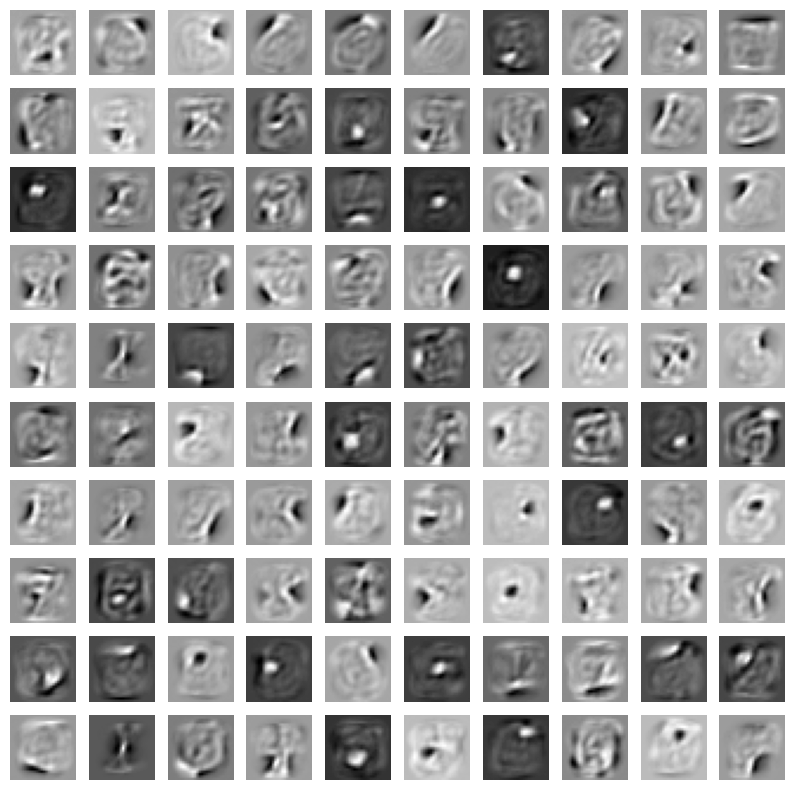

In [12]:
weights = boltzmann_machine._weights.T
weights = np.reshape(weights, (weights.shape[0], 28, 28))

n_rows = 10
n_columns = 10

fig, axes = plt.subplots(n_rows, n_columns, figsize=(10, 10))

i = 0
for row in range(n_rows):
    for column in range(n_columns):
        ax = axes[row, column]
        ax.axis("off")
        ax.imshow(weights[i], cmap="gray")
        i += 1

From the average scores on the different digits we can see that the results are overall quite similar among them.<br>
One outlier is the scores of the images for ones, as the UQI is surprisingly low while the MSE is lower than the other digits. This is possibly because of how the UQI is defined and it might simply not work well in this case. Visually comparing some of the images for ones to their reconstruction shows that they are more similar than one might expect when seeing the average UQI, being more in line with the low MSE.<br>
Sevens also have a similar behaviour to a lesser degree, while zeros have slightly higher UQI compared to other digits. 

In [13]:
for i in range(10):
    indices = np.where(test_labels==i)[0]
    loss_avg = mse(ts_images[indices], reconstructed_test[indices])
    uqi_avg = 0
    for index in indices:
        uqi_avg += uqi(ts_images_reshaped[index], reconstructed_test_reshaped[index])
    uqi_avg /= indices.shape[0]
    print(f"Digit: {i}. Average MSE: {np.round(loss_avg, 4)}. Average UQI: {np.round(uqi_avg, 4)}.")

Digit: 0. Average MSE: 0.0199. Average UQI: 0.8506.
Digit: 1. Average MSE: 0.0064. Average UQI: 0.5567.
Digit: 2. Average MSE: 0.022. Average UQI: 0.7834.
Digit: 3. Average MSE: 0.0185. Average UQI: 0.7807.
Digit: 4. Average MSE: 0.0167. Average UQI: 0.7564.
Digit: 5. Average MSE: 0.0194. Average UQI: 0.762.
Digit: 6. Average MSE: 0.0186. Average UQI: 0.7745.
Digit: 7. Average MSE: 0.0138. Average UQI: 0.7342.
Digit: 8. Average MSE: 0.0215. Average UQI: 0.7691.
Digit: 9. Average MSE: 0.0142. Average UQI: 0.7726.


Positive examples of images reconstructed by the RBM for some handpicked test samples, one for each digit, with the MSE and UQI scores computed between the original image and the one reconstructed by the RBM.<br>
The reconstructed images are overall quite close to the original ones, though they are all slightly blurrier.

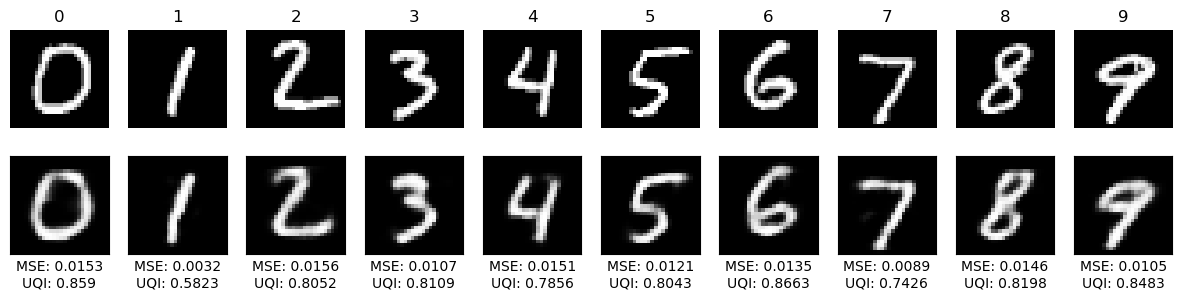

In [14]:
indices = [10, 5, 1, 30, 27, 2798, 1831, 0, 110, 9]
plot_images(indices, ts_images_reshaped, reconstructed_test_reshaped, test_labels)

More handpicked examples for each digit, this time of samples that the RBM has trouble in reconstructing properly. While the overall shape is generally still present there is either a lot of noise or missing parts. For the samples for the eight and the nine the reconstruction looks more like a three, rather than the original digit.<br>
In general, when the original digit is drawn in a way that deviates too much from the "average", be it line thickness or shape, the reconstruction obtained from the RBM seems to possibly suffer in quality.

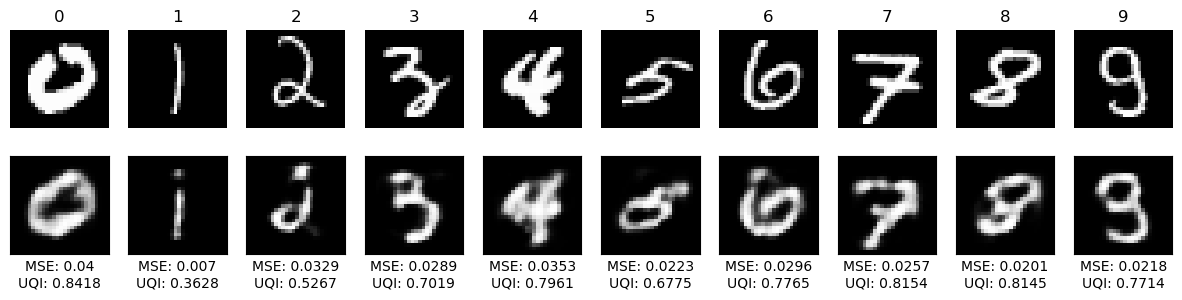

In [15]:
indices = [25, 40, 47, 87, 95, 167, 11, 64, 61, 479]
plot_images(indices, ts_images_reshaped, reconstructed_test_reshaped, test_labels)

Some extra examples where the digits are written a bit differently than usual but the RBM is still able to reconstruct them rather accurately.

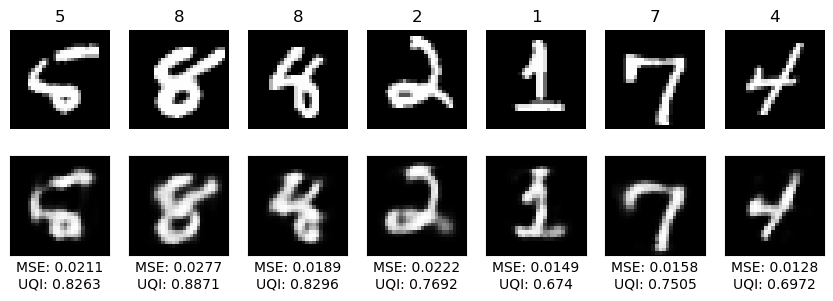

In [16]:
indices = [8, 4960, 4956, 6340, 4013, 2505, 7510]
plot_images(indices, ts_images_reshaped, reconstructed_test_reshaped, test_labels)

On the other hand, in the following examples the RBM is failing quite badly. In the first two the original images have dense areas and thick lines, especially the 4, resulting in extremely noisy reconstructions. The middle three have the opposite problem, where the lines are too thin, making the RBM miss some parts while reconstructing the samples. Lastly, in the last two examples, the RBM outputs images that look quite believable, although the digit being represented is changed.

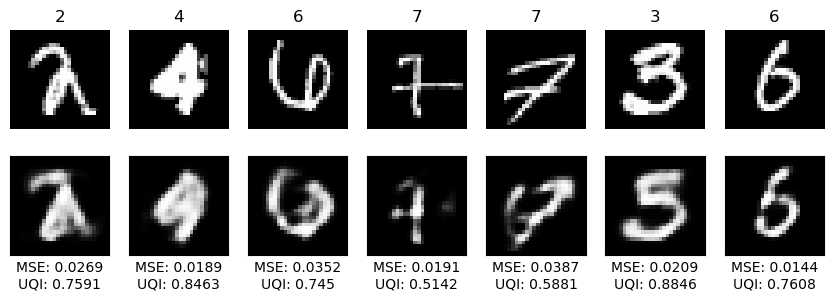

In [17]:
indices = [1551, 8107, 3749, 3751, 1941, 6511, 386]
plot_images(indices, ts_images_reshaped, reconstructed_test_reshaped, test_labels)

## Final Remarks

For this assignment it was particularly interesting to see how the RBM reconstructs the images starting from their encoding in the hidden layer. Considering that the model is relatively simple, the results are quite nice overall, as the reconstructions are similar to the original images for the most part, at least when the digits are drawn in a more "standard" way. With more in depth model selection RBMs might be able to get even better results, as I only tried a small number of hyperparameters. Of course, a validation set would also be needed to avoid overfitting as much as possible.<br>
On picking a quantitative measure to get an objective idea of how good the results were, I decided to try out how the UQI behaves for this task as it looked rather promising while searching for image comparison specific metrics. After looking at the various results obtained, the UQI turned out to be decent, but not quite perfect. The main example of this is the scores for the samples relative to digit 1, being extremely low despite the reconstructed images being very similar to the original ones. Moreover, it is unfortunately very slow to compute during training.<br>
On the topic of speed, the training is somewhat slow and could stand to be optimized somehow.<br>
To get a better analysis one could also try more quantitative measures to better get an idea of how good the reconstructions are. Implementing more of the tips given in the [guide](https://www.cs.toronto.edu/~hinton/absps/guideTR.pdf) to training an RBM would probably lead to better results, too.